In [1]:
import sys
sys.path.append('../../..')
from viz.match_data import extract_match_complete
from viz.pass_network import plot_pass_network
from viz.pass_analysis import plot_pass_flow, plot_pass_hull
from viz.shot_xg import plot_shot_xg
from viz.shot_map_report import plot_shot_report
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datos del partido
WS_ID = 1913901
US_ID = 29173
LEAGUE = 'ESP-La Liga'
SEASON = '25-26'
HOME_TEAM = 'Villarreal'
AWAY_TEAM = 'Girona'
MATCH_DATE = '2025-08-24'

# Extracción completa de datos
result = extract_match_complete(
    ws_id=WS_ID,
    us_id=US_ID,
    league=LEAGUE,
    season=SEASON,
    home_team=HOME_TEAM,
    away_team=AWAY_TEAM,
    match_date=MATCH_DATE
)


Extracting: Villarreal vs Girona (2025-08-24)
--------------------------------------------------
1. match_events.csv: 1902 events
2. player_network.csv: 298 records
3. match_aggregates.csv: 68 records
4. spatial_analysis.csv: 50 spatial records
5. match_info.csv: 94 info records

Shots: 24 | Goals: 5 | xG: 3.14


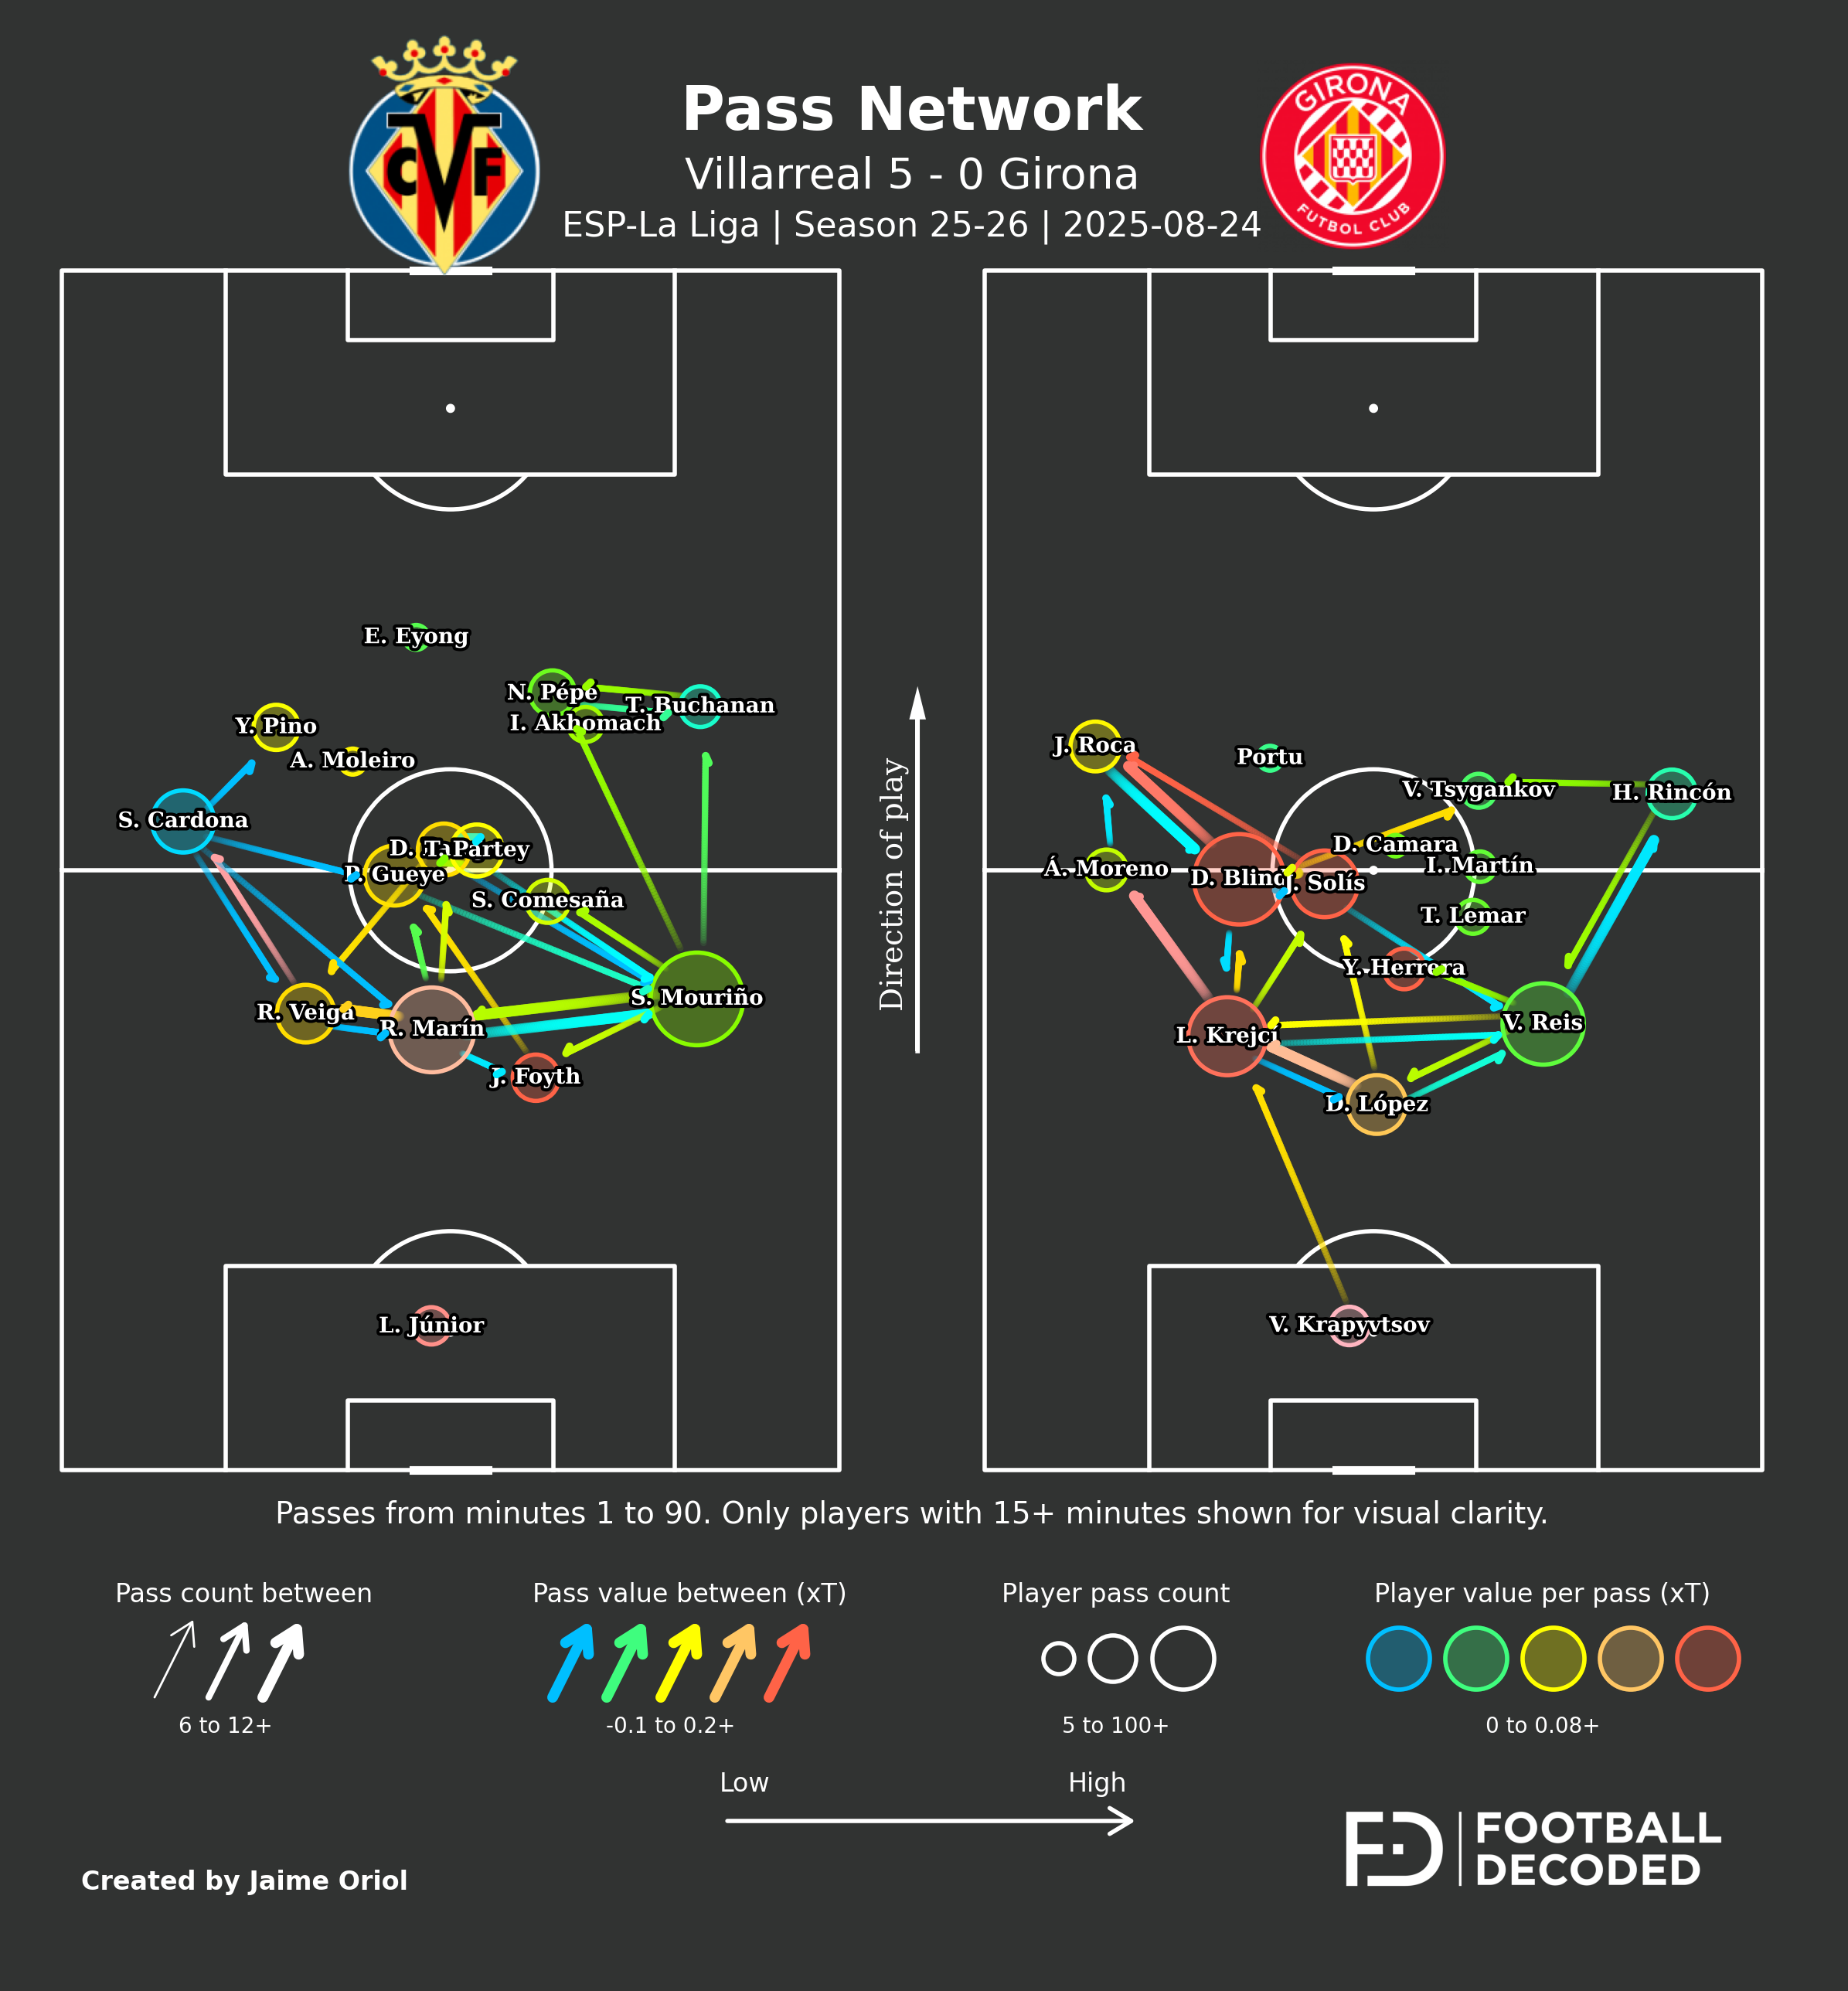

In [3]:
fig_network = plot_pass_network(
    network_csv_path='../../../viz/data/player_network.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    aggregates_csv_path='../../../viz/data/match_aggregates.csv',
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

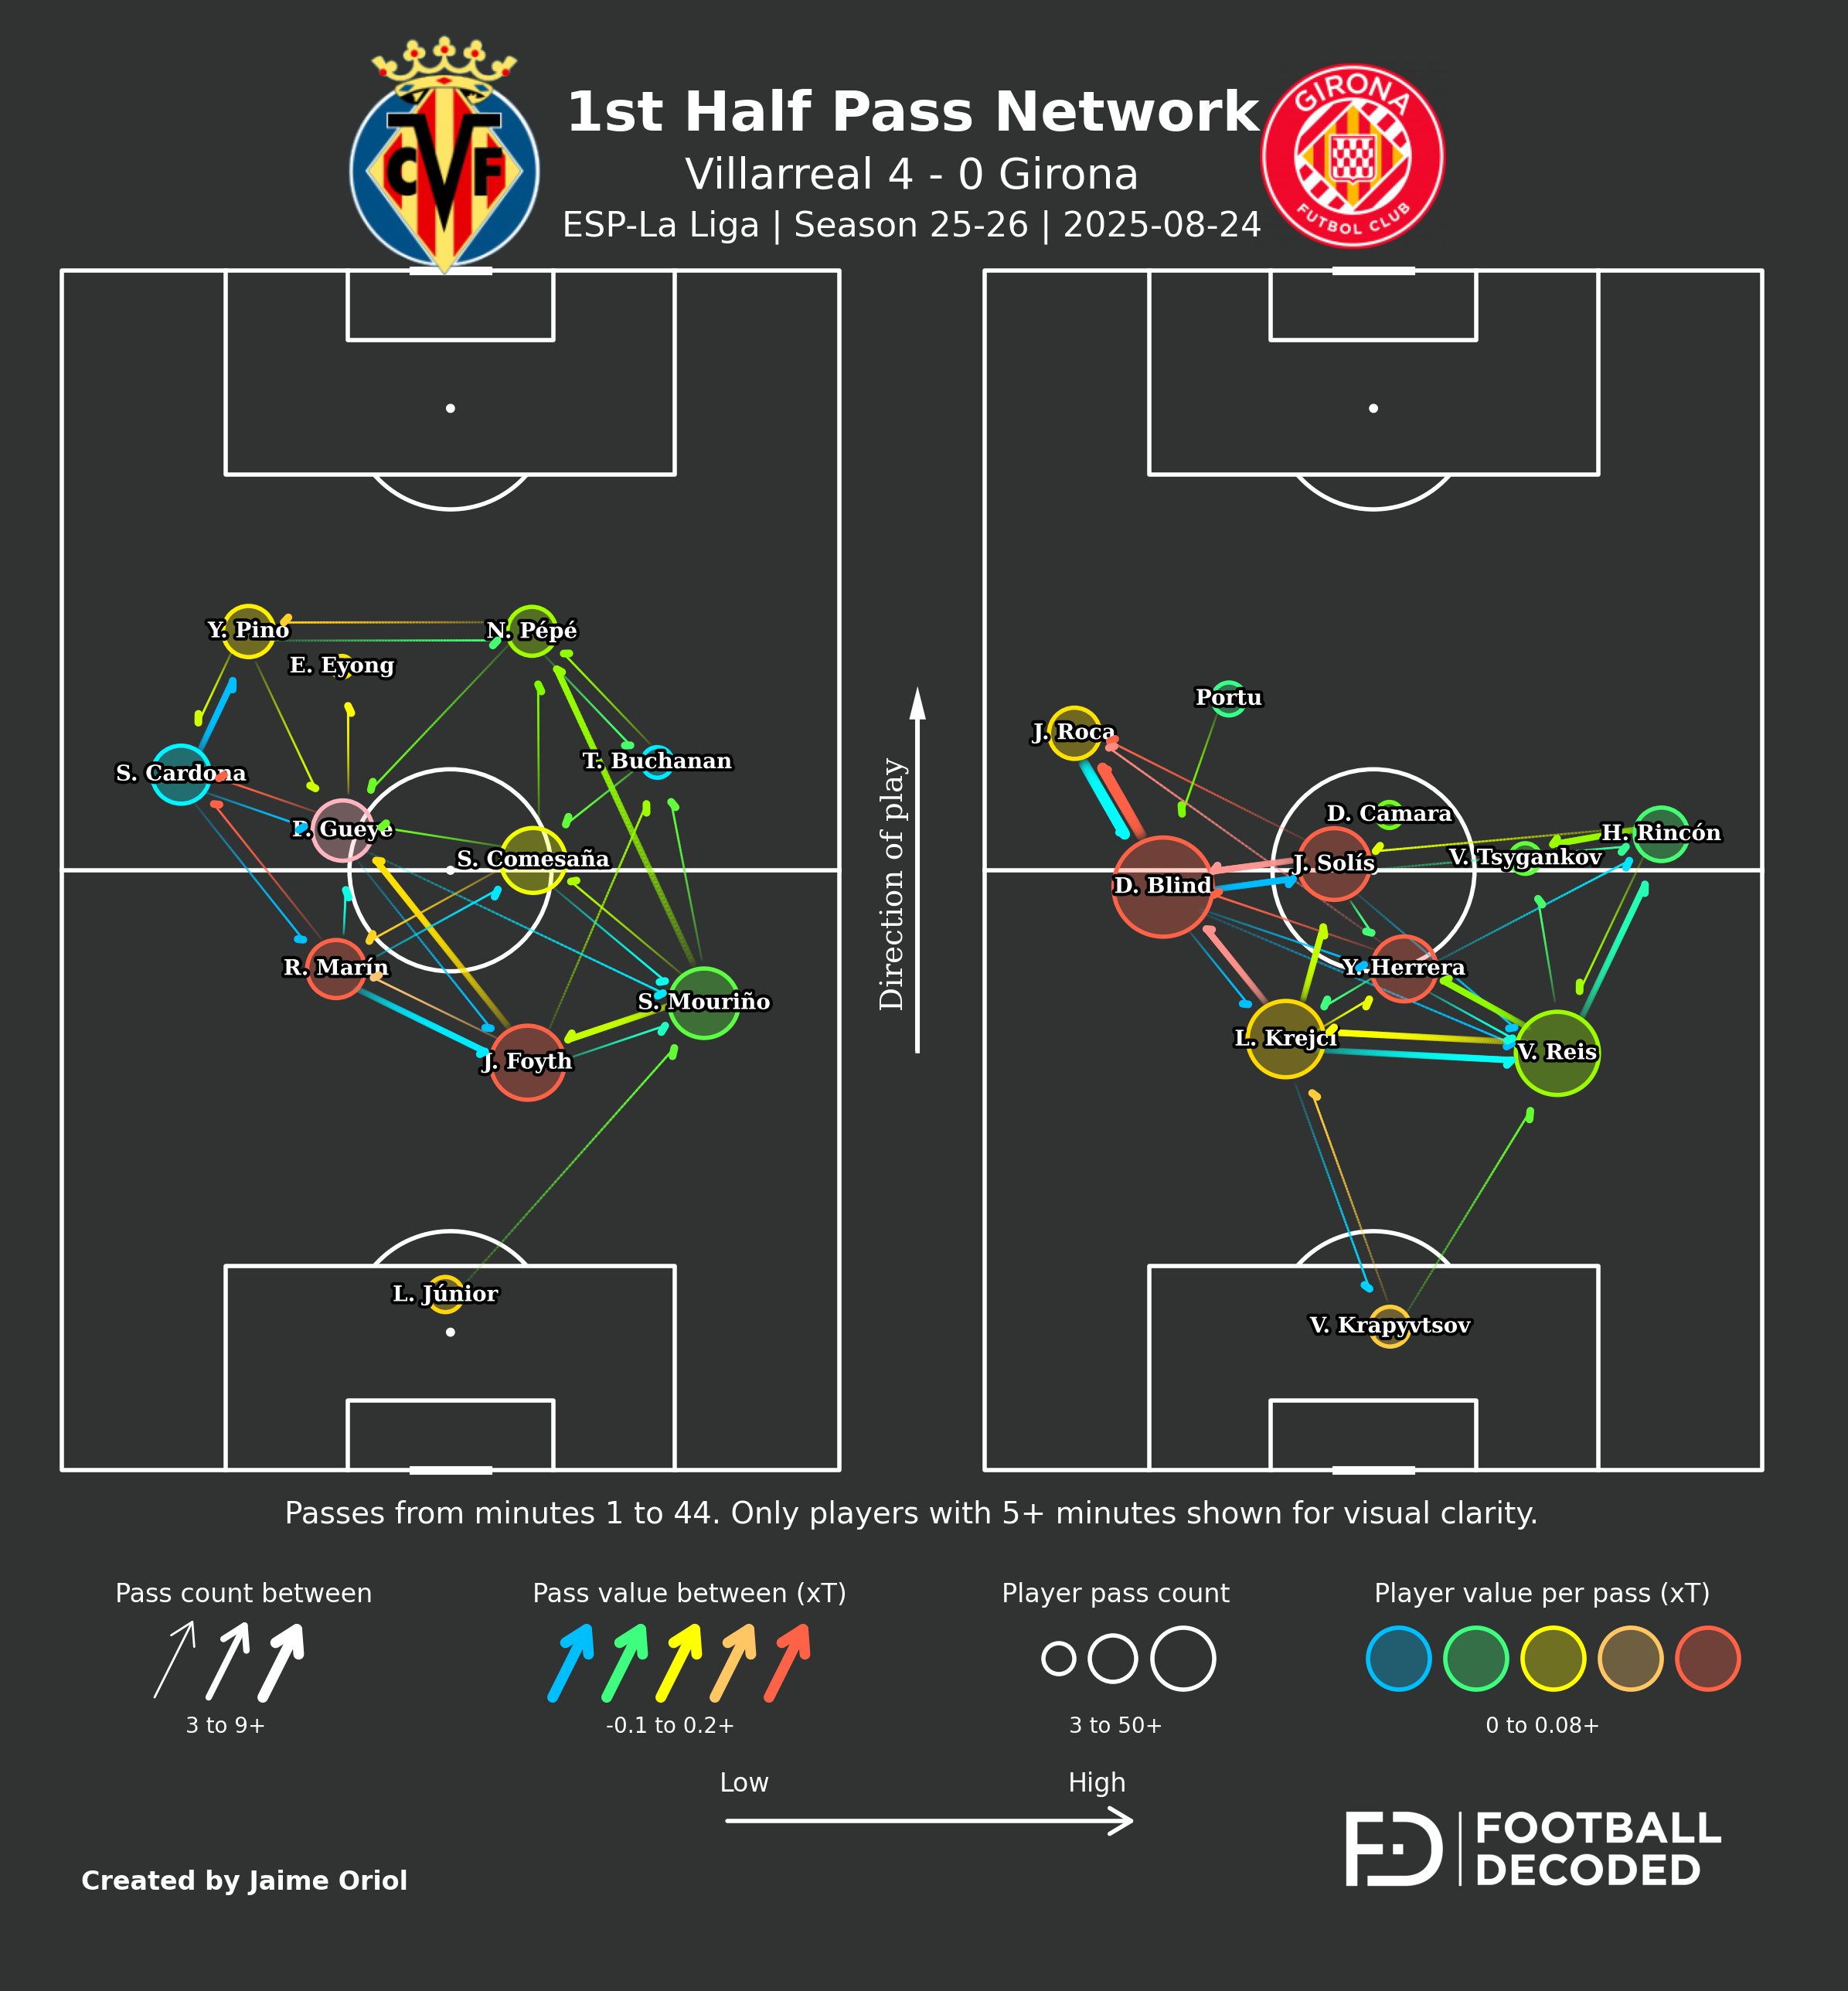

In [4]:
# Pass network primer tiempo (jugadores >5 minutos primer tiempo)
from viz.pass_network import plot_pass_network_first_half
fig_network_44 = plot_pass_network_first_half(
    network_csv_path='../../../viz/data/player_network.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    aggregates_csv_path='../../../viz/data/match_aggregates.csv',
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

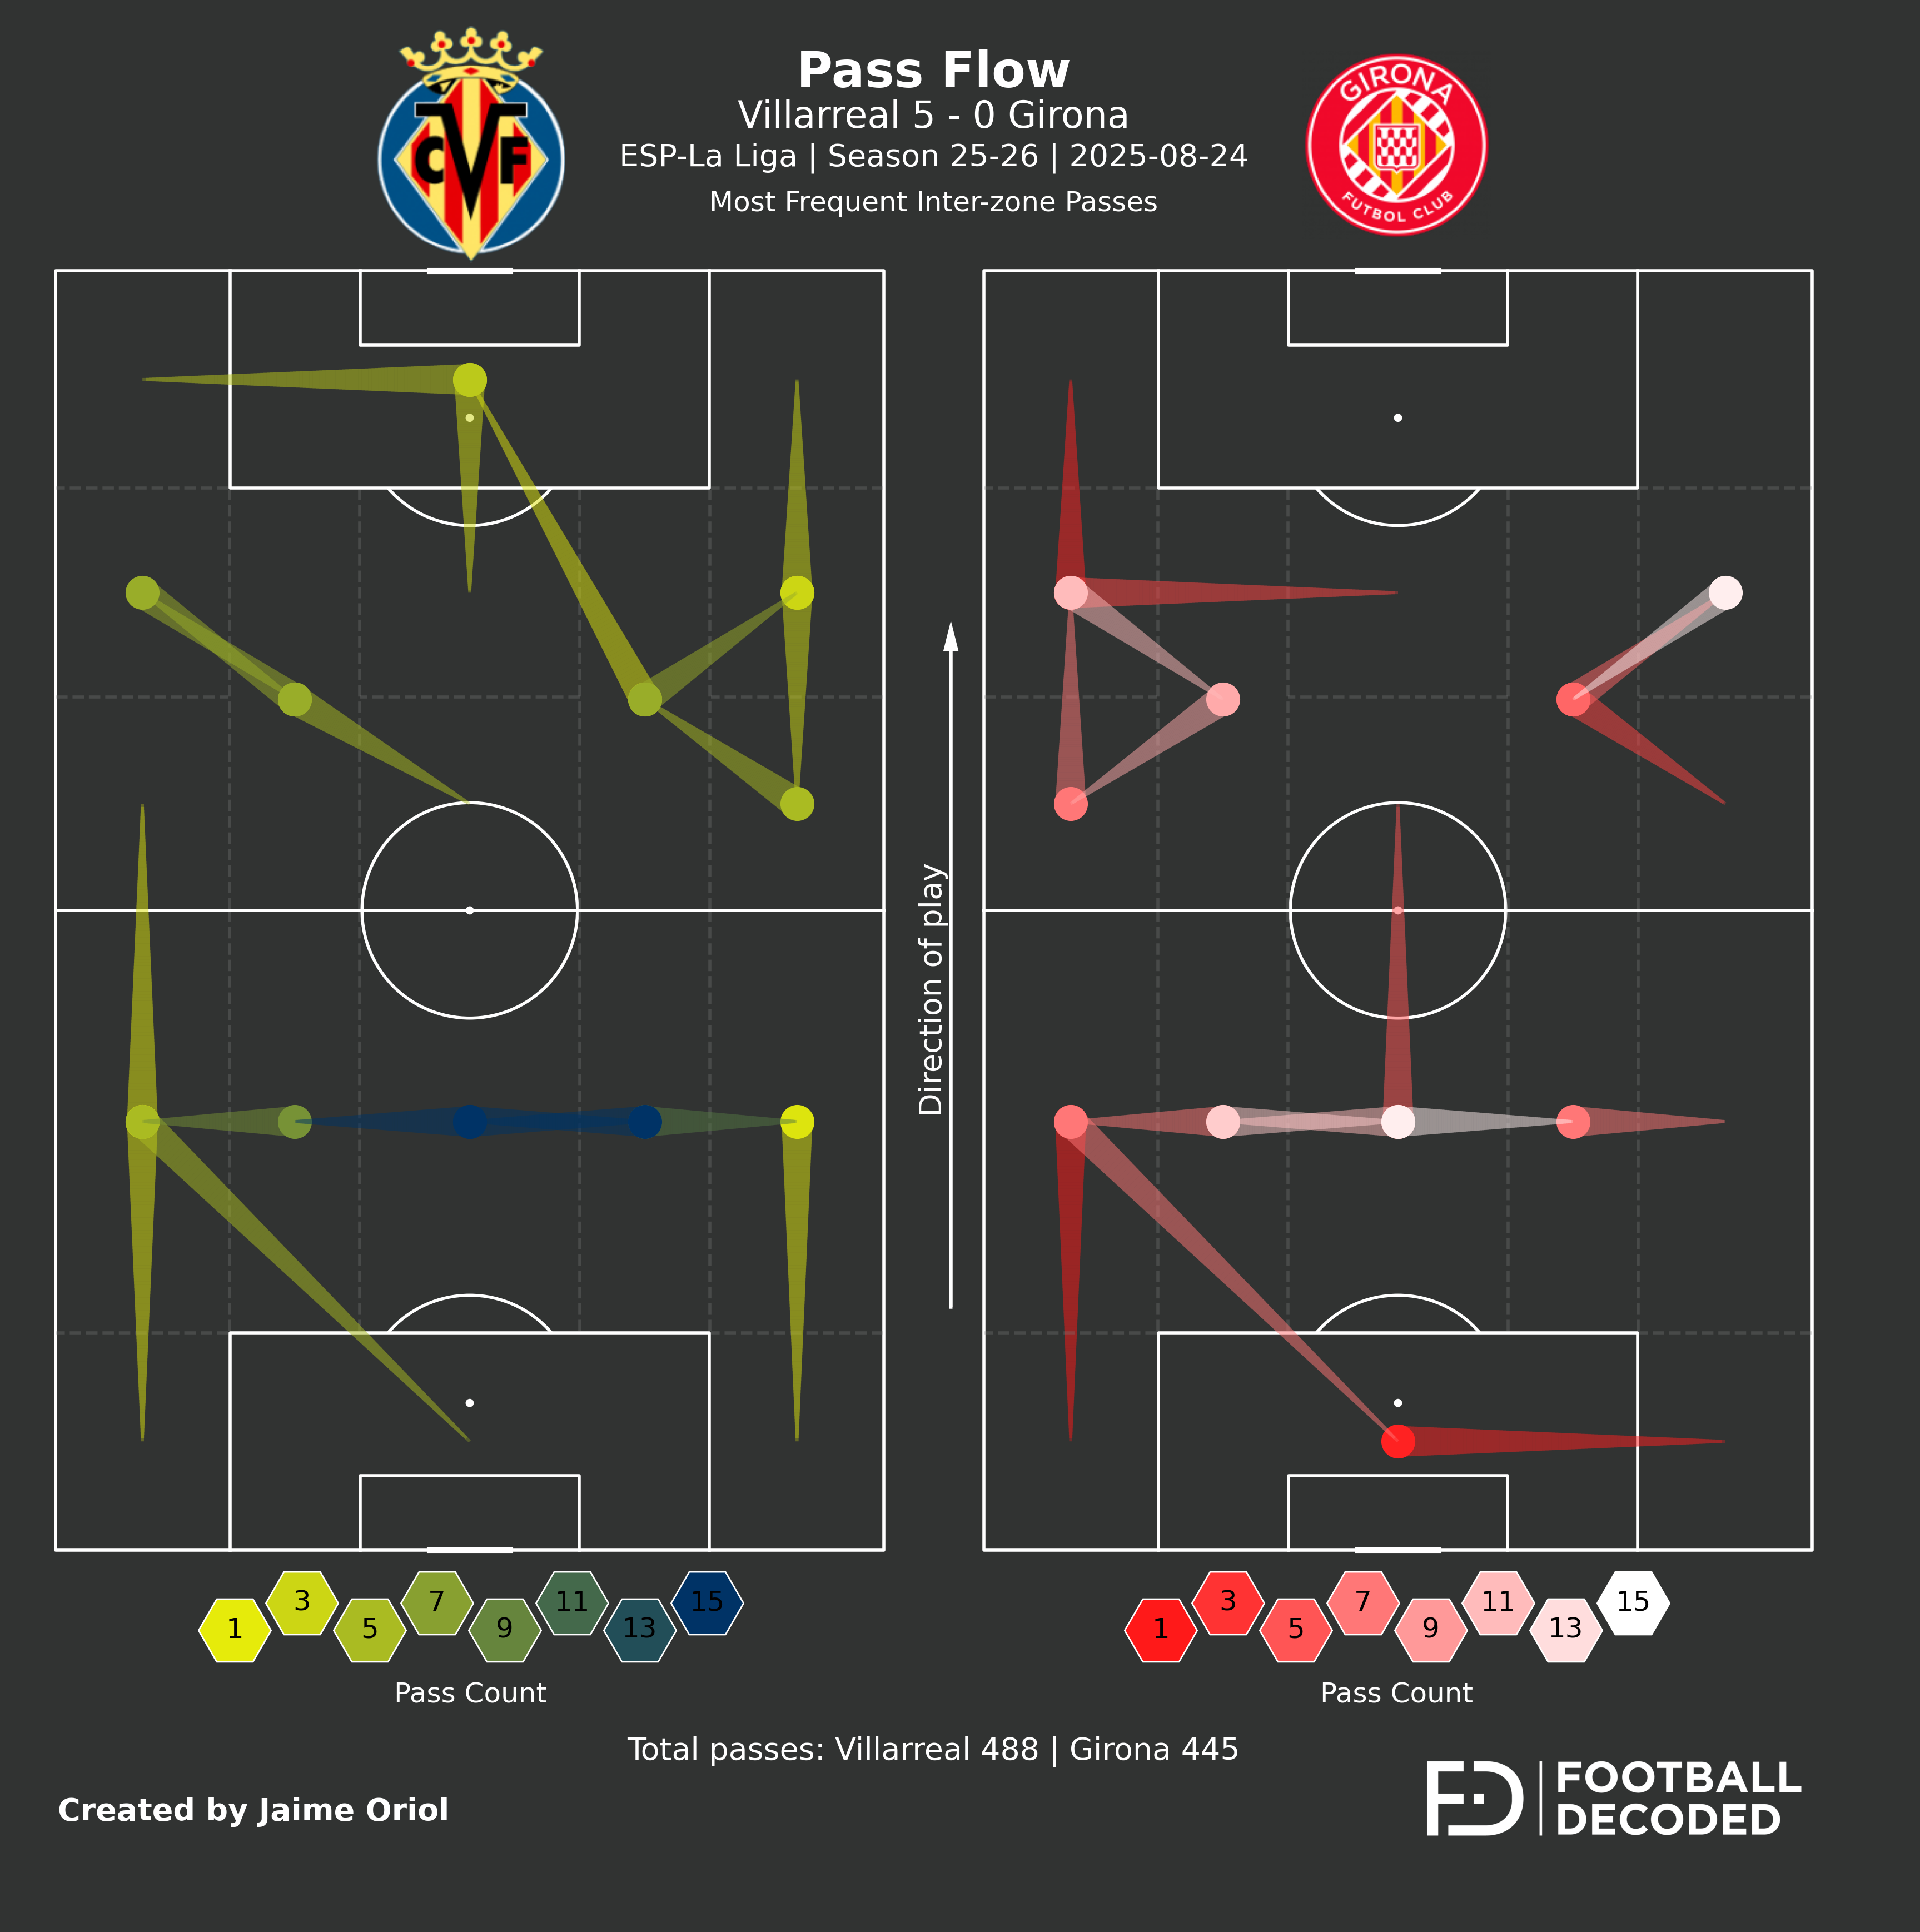

In [5]:
# Pass Flow
fig_flow = plot_pass_flow(
    events_csv_path='../../../viz/data/match_events.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    home_colors=['#FFFF00', '#003366'],
    away_colors=['#FF0000', '#FFFFFF'],
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

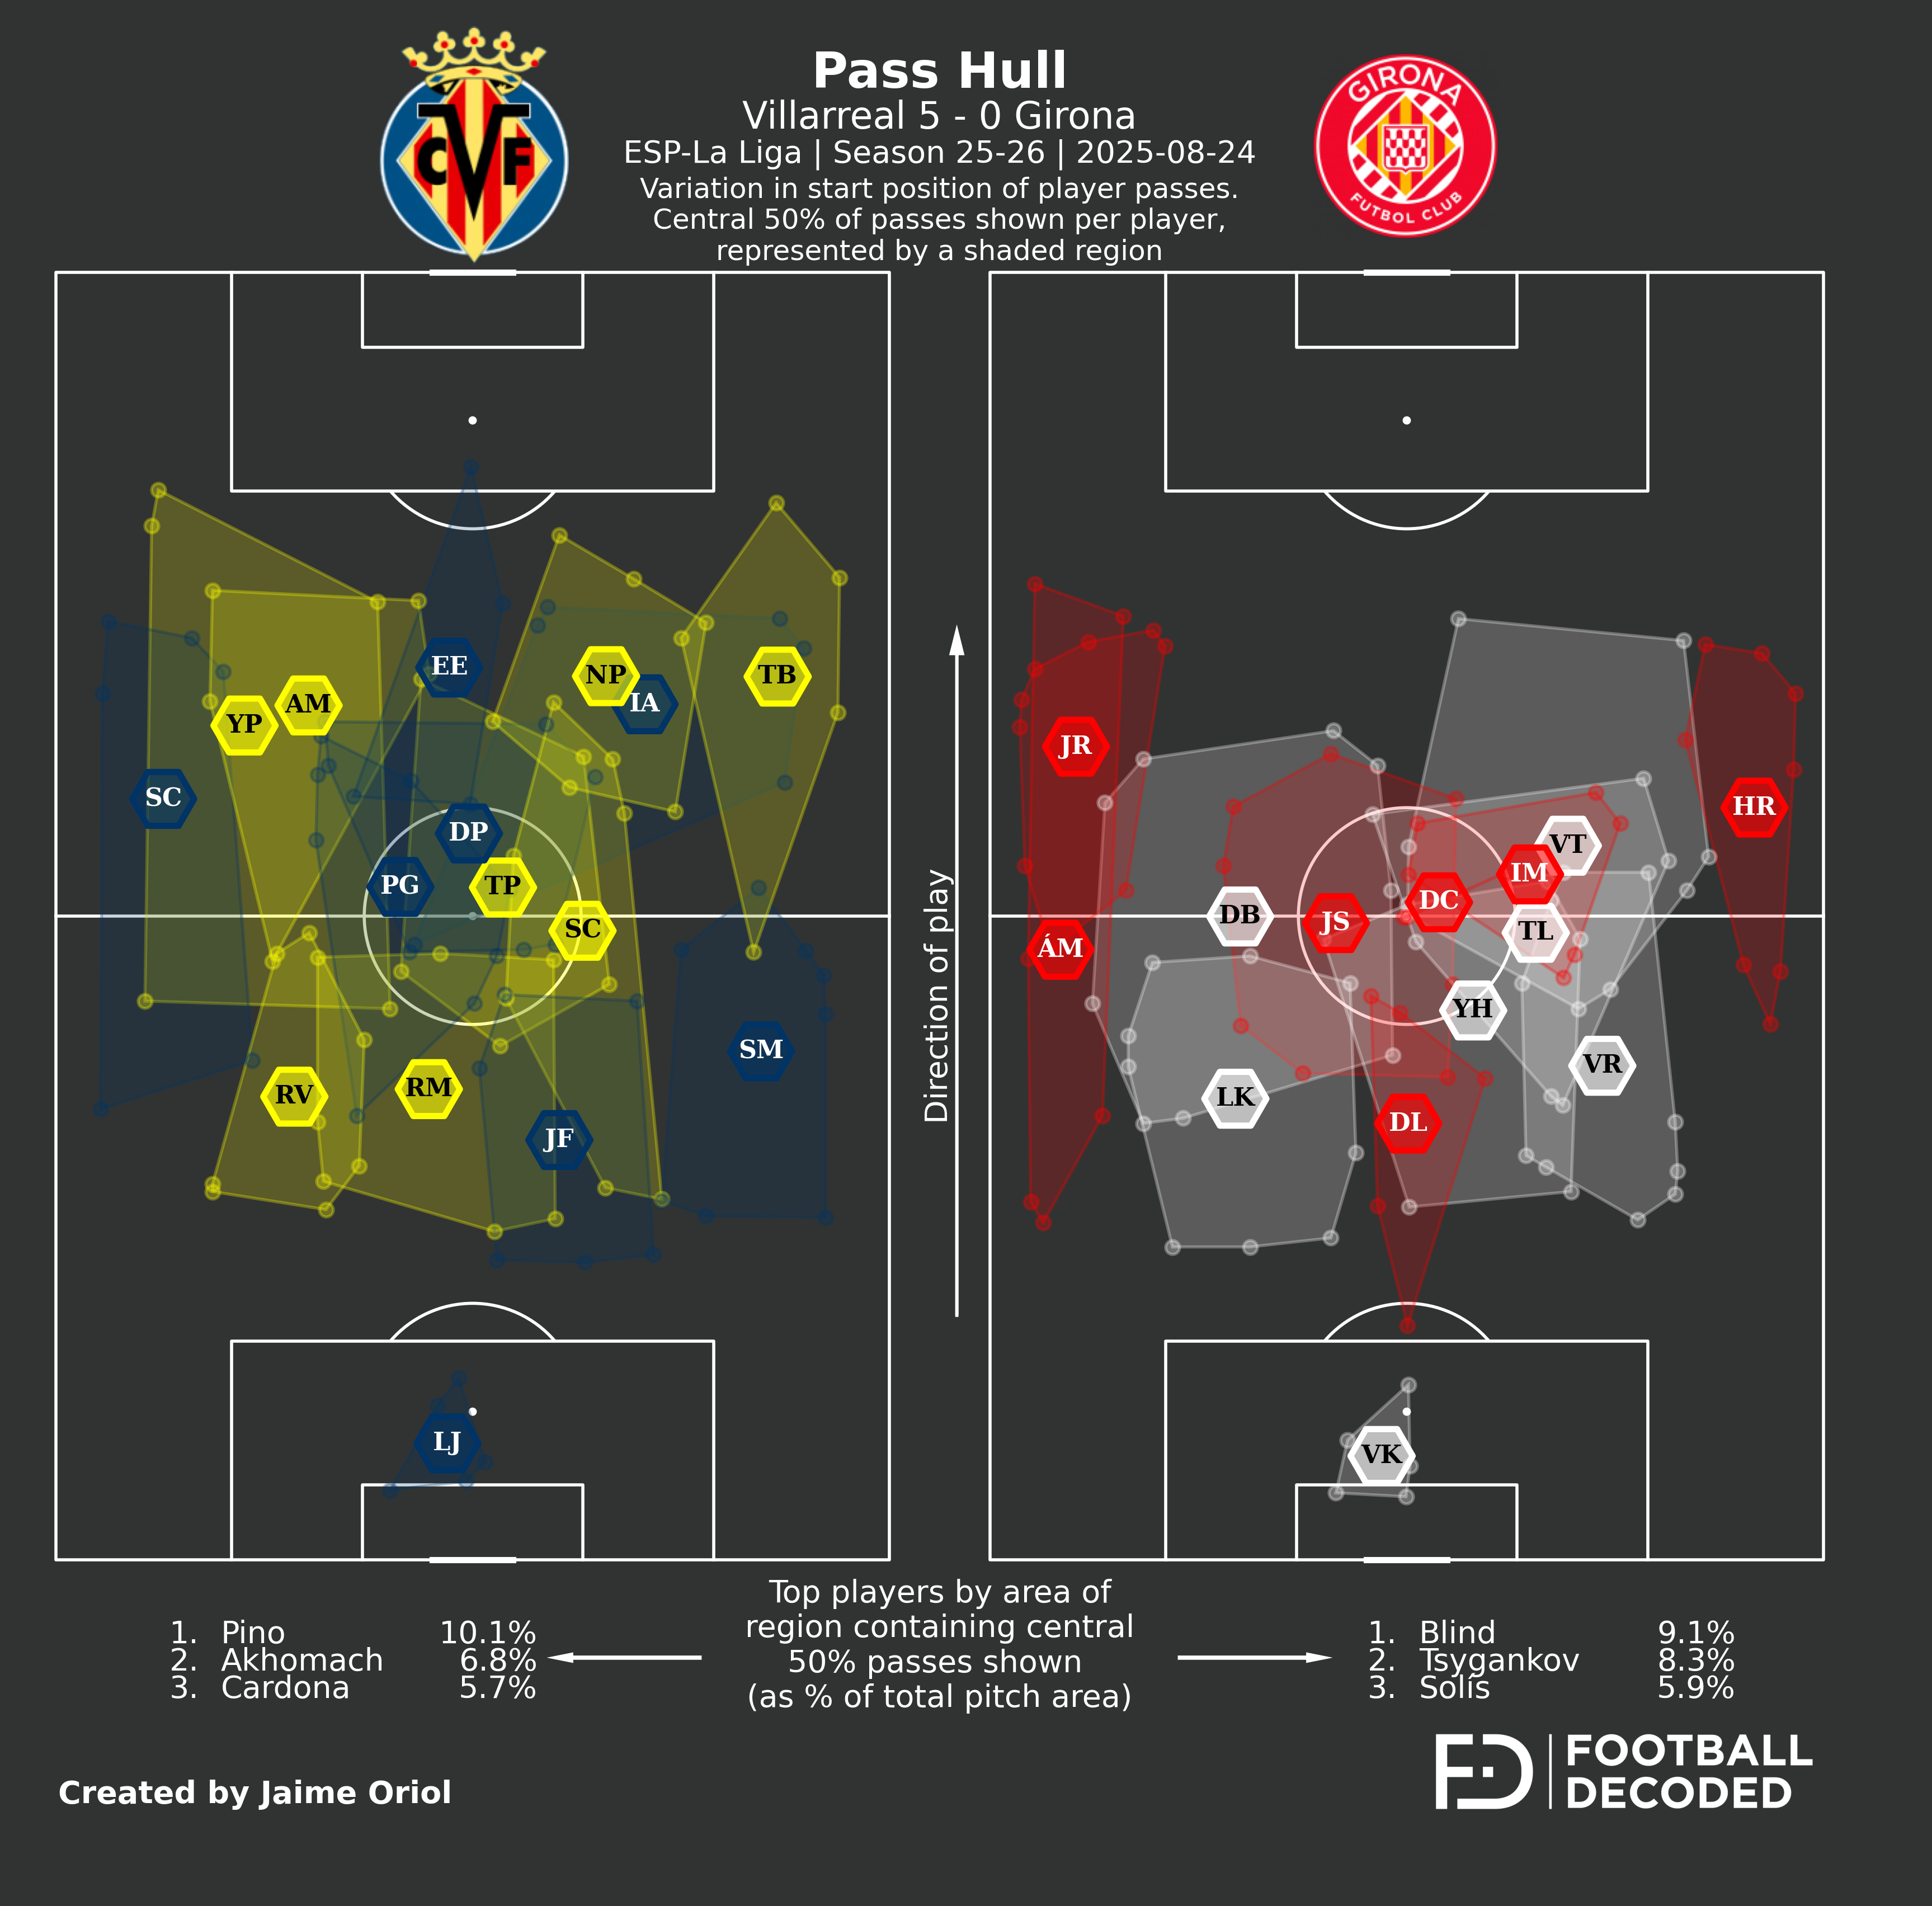

In [6]:
# Pass Hull
fig_hull = plot_pass_hull(
    events_csv_path='../../../viz/data/match_events.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    aggregates_csv_path='../../../viz/data/match_aggregates.csv',
    home_colors=['#FFFF00', '#003366'],
    away_colors=['#FF0000', '#FFFFFF'],
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

Disparos: 24 | Goles: 5 | xG: 3.143


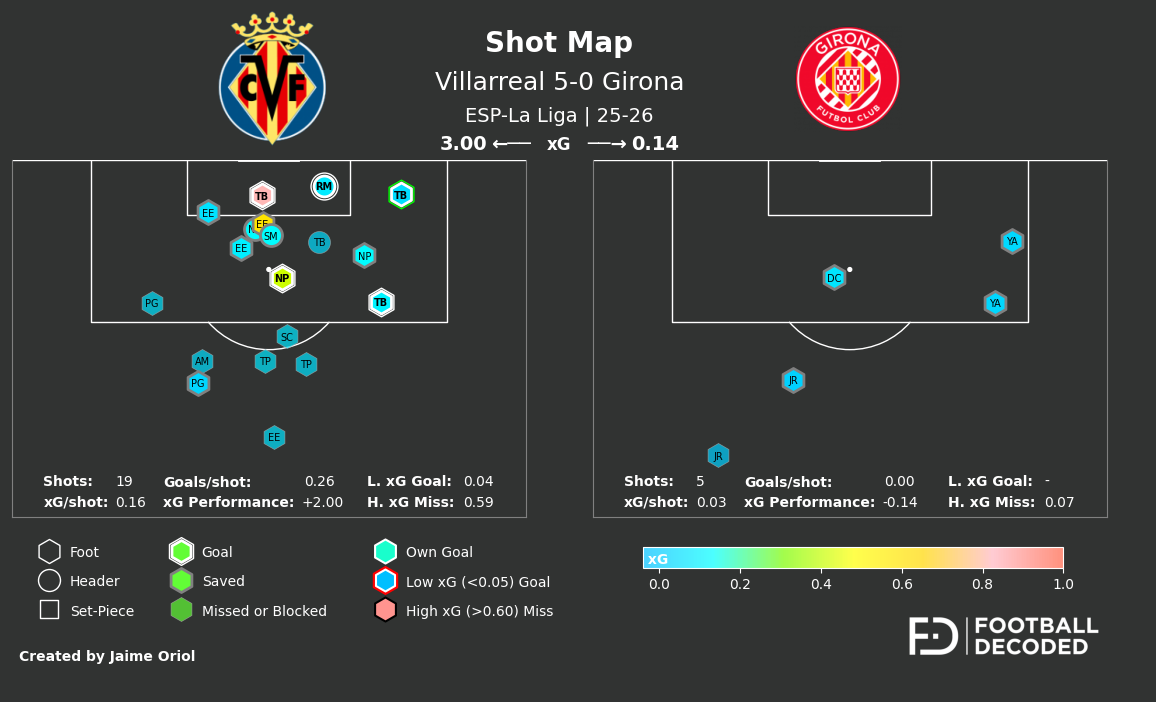

In [7]:
# Preparar datos de disparos
def create_shots_csv():
    events = pd.read_csv('../../../viz/data/match_events.csv')
    shots = events[events['event_type'].str.contains('Shot|Goal', case=False, na=False)].copy()
    shots['is_goal'] = shots['event_type'] == 'Goal'
    shots['body_part'] = shots['qualifiers'].str.contains('Head', na=False).map({True: 'Head', False: 'Foot'})
    shots['xg'] = pd.to_numeric(shots['xg'], errors='coerce').fillna(0.0)
    shots.to_csv('../../../viz/data/shots_temp.csv', index=False)
    print(f"Disparos: {len(shots)} | Goles: {shots['is_goal'].sum()} | xG: {shots['xg'].sum():.3f}")
    return shots

shots_data = create_shots_csv()

# Shot Map Report
fig_report = plot_shot_report(
    csv_path='../../../viz/data/shots_temp.csv',
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png',
    season='25-26'
)

Disparos Tajon Buchanan:
      minute   event_type     xg     x     y
38       1.0  MissedShots  0.038  91.4  41.8
335     15.0         Goal  0.038  96.4  28.6
536     27.0         Goal  0.814  96.3  51.1
1317    63.0         Goal  0.103  85.1  31.8
Resumen: 4 disparos | 3 goles | 0.993 xG


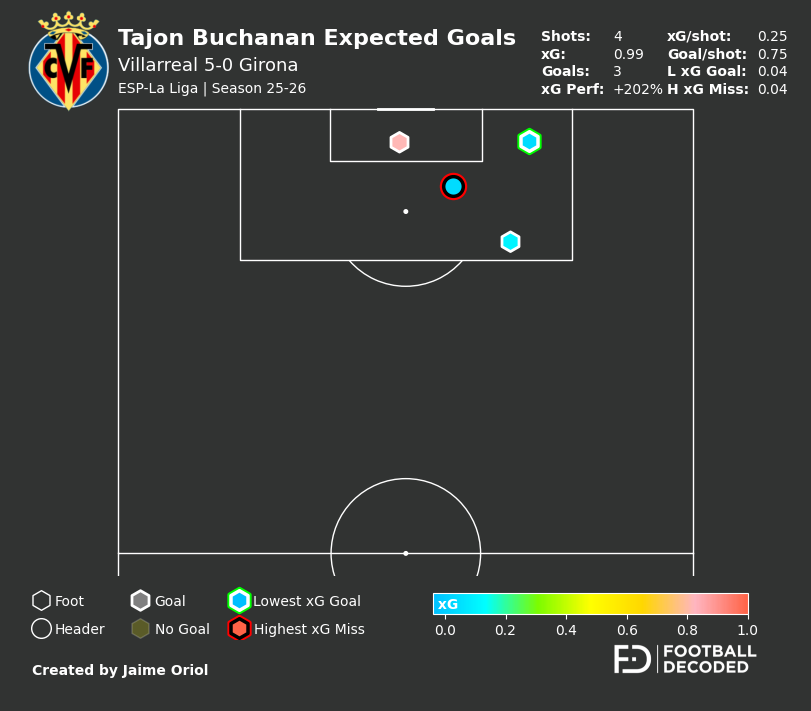

In [8]:
# Análisis Tajon Buchanan
buchanan_shots = shots_data[shots_data['player'].str.contains('Tajon Buchanan', case=False, na=False)]
print("Disparos Tajon Buchanan:")
print(buchanan_shots[['minute', 'event_type', 'xg', 'x', 'y']].round(3))
print(f"Resumen: {len(buchanan_shots)} disparos | {buchanan_shots['is_goal'].sum()} goles | {buchanan_shots['xg'].sum():.3f} xG")

# Visualización xG
fig_buchanan = plot_shot_xg(
    csv_path='../../../viz/data/shots_temp.csv',
    filter_by='Tajon Buchanan',
    logo_path='../../logos/LaLiga/Villarreal CF.png',
    title_text='Tajon Buchanan Expected Goals',
    subtitle_text='Villarreal 5-0 Girona',
    subsubtitle_text='ESP-La Liga | Season 25-26'
)

In [9]:
# Custom stats extraction function
def extract_custom_stats(player_name, events_df):
    player_events = events_df[events_df['player'] == player_name]
    
    return {
        'goals': len(player_events[player_events['event_type'] == 'Goal']),
        'shots_total': len(player_events[player_events['event_type'].str.contains('Shot', na=False)]),
        'xg_total': player_events['xg'].fillna(0).sum(),
        'assists': len(player_events[player_events['is_assist'] == True]),
        'pre_assists_events': len(player_events[player_events['is_pre_assist'] == True]),
        'take_ons': len(player_events[player_events['event_type'] == 'TakeOn']),
        'tackles': len(player_events[player_events['event_type'] == 'Tackle']),
        'interceptions': len(player_events[player_events['event_type'] == 'Interception']),
        'clearances': len(player_events[player_events['event_type'] == 'Clearance']),
        'blocks': len(player_events[player_events['event_type'] == 'Block']),
        'ball_recoveries': len(player_events[player_events['event_type'] == 'BallRecovery']),
        'errors': len(player_events[player_events['event_type'] == 'Error']),
        'crosses': len(player_events[player_events['is_cross'] == True]),
        'through_balls': len(player_events[player_events['is_through_ball'] == True]),
        'long_balls': len(player_events[player_events['is_longball'] == True]),
        'headers': len(player_events[player_events['is_header'] == True])
    }
    

# METRICAS DISPONIBLES PARA STATS TABLES:

"""
=== FROM match_aggregates.csv ===
- minutes_active, total_actions, actions_per_minute
- passes_attempted, passes_completed, pass_completion_pct, progressive_passes  
- offensive_actions, defensive_actions, neutral_actions
- xthreat_total, xthreat_per_action
- pre_assists, carries, progressive_carries, carry_distance_total
- passes_to_goal, passes_to_shot, key_passes, box_entries
- position_variance_x, position_variance_y

=== FROM custom_stats function ===  
- goals, shots_total, xg_total, assists, pre_assists_events
- take_ons, tackles, interceptions, clearances, blocks
- ball_recoveries, errors, crosses, through_balls, long_balls, headers
"""


'\n=== FROM match_aggregates.csv ===\n- minutes_active, total_actions, actions_per_minute\n- passes_attempted, passes_completed, pass_completion_pct, progressive_passes  \n- offensive_actions, defensive_actions, neutral_actions\n- xthreat_total, xthreat_per_action\n- pre_assists, carries, progressive_carries, carry_distance_total\n- passes_to_goal, passes_to_shot, key_passes, box_entries\n- position_variance_x, position_variance_y\n\n=== FROM custom_stats function ===  \n- goals, shots_total, xg_total, assists, pre_assists_events\n- take_ons, tackles, interceptions, clearances, blocks\n- ball_recoveries, errors, crosses, through_balls, long_balls, headers\n'

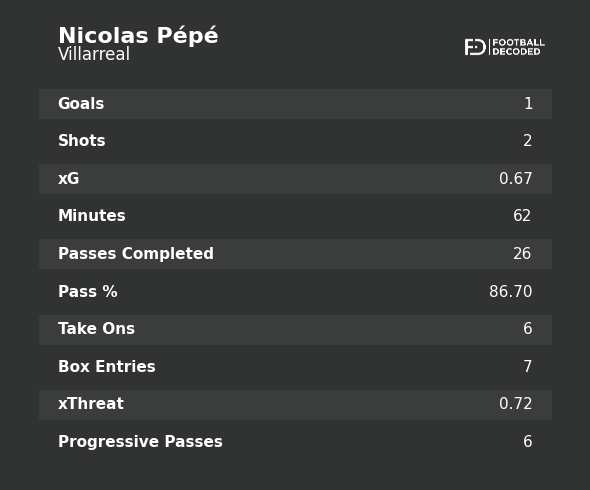

In [10]:
# Importar función minimal stats
from viz.stats_table import create_minimal_stats_table

# 1. NICOLAS PEPÉ
events = pd.read_csv('../../../viz/data/match_events.csv')
aggregates = pd.read_csv('../../../viz/data/match_aggregates.csv')
pepe_agg = aggregates[aggregates['entity_name'].str.contains('Nicolas Pépé', case=False, na=False)].iloc[0]

# Extraer stats personalizadas
pepe_custom = extract_custom_stats('Nicolas Pépé', events)

# Datos para la tabla (10 métricas)
pepe_metrics = [
    pepe_custom['goals'],
    pepe_custom['shots_total'], 
    pepe_custom['xg_total'],
    int(pepe_agg['minutes_active']),
    int(pepe_agg['passes_completed']),
    pepe_agg['pass_completion_pct'],
    pepe_custom['take_ons'],
    int(pepe_agg['box_entries']),
    pepe_agg['xthreat_total'],
    int(pepe_agg['progressive_passes'])
]

pepe_titles = [
    'Goals', 'Shots', 'xG', 'Minutes', 'Passes Completed', 
    'Pass %', 'Take Ons', 'Box Entries', 'xThreat', 'Progressive Passes'
]

fig_pepe = create_minimal_stats_table(
    player_name='Nicolas Pépé',
    team_name='Villarreal',
    metrics_data=pepe_metrics,
    metrics_titles=pepe_titles,
    save_path='pepe_stats.png'
)

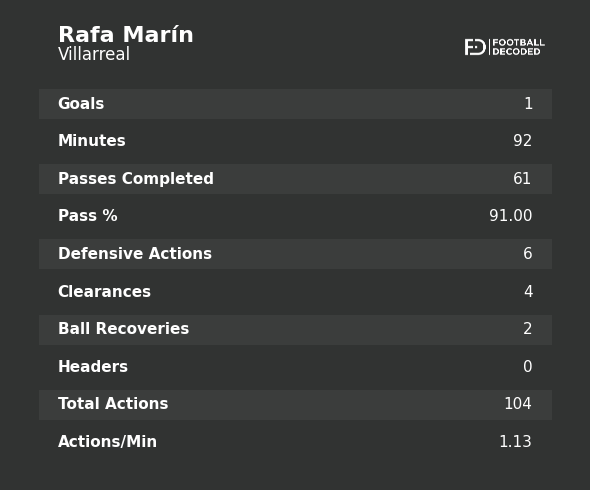

In [11]:
# 2. RAFA MARÍN  
rafa_agg = aggregates[aggregates['entity_name'].str.contains('Rafa Marín', case=False, na=False)].iloc[0]
rafa_custom = extract_custom_stats('Rafa Marín', events)

# Datos para la tabla (10 métricas)
rafa_metrics = [
    rafa_custom['goals'],
    int(rafa_agg['minutes_active']),
    int(rafa_agg['passes_completed']),
    rafa_agg['pass_completion_pct'],
    int(rafa_agg['defensive_actions']),
    rafa_custom['clearances'],
    rafa_custom['ball_recoveries'],
    rafa_custom['headers'],
    int(rafa_agg['total_actions']),
    rafa_agg['actions_per_minute']
]

rafa_titles = [
    'Goals', 'Minutes', 'Passes Completed', 'Pass %', 'Defensive Actions',
    'Clearances', 'Ball Recoveries', 'Headers', 'Total Actions', 'Actions/Min'
]

fig_rafa = create_minimal_stats_table(
    player_name='Rafa Marín',
    team_name='Villarreal', 
    metrics_data=rafa_metrics,
    metrics_titles=rafa_titles,
    save_path='rafa_stats.png'
)


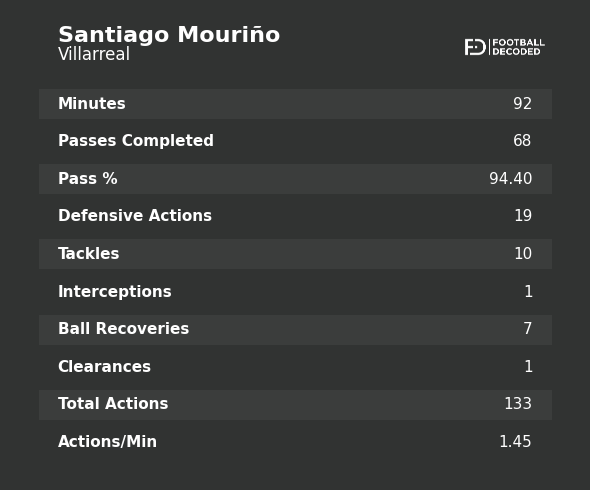

In [12]:
# 3. SANTIAGO MOURIÑO
mourino_agg = aggregates[aggregates['entity_name'].str.contains('Santiago Mouriño', case=False, na=False)].iloc[0]
mourino_custom = extract_custom_stats('Santiago Mouriño', events)

# Datos para la tabla (10 métricas)
mourino_metrics = [
    int(mourino_agg['minutes_active']),
    int(mourino_agg['passes_completed']),
    mourino_agg['pass_completion_pct'],
    int(mourino_agg['defensive_actions']),
    mourino_custom['tackles'],
    mourino_custom['interceptions'],
    mourino_custom['ball_recoveries'],
    mourino_custom['clearances'],
    int(mourino_agg['total_actions']),
    mourino_agg['actions_per_minute']
]

mourino_titles = [
    'Minutes', 'Passes Completed', 'Pass %', 'Defensive Actions',
    'Tackles', 'Interceptions', 'Ball Recoveries', 'Clearances', 
    'Total Actions', 'Actions/Min'
]

fig_mourino = create_minimal_stats_table(
    player_name='Santiago Mouriño',
    team_name='Villarreal',
    metrics_data=mourino_metrics, 
    metrics_titles=mourino_titles,
    save_path='mourino_stats.png'
)